# Distracting Drivers Recognition with Deep Learning

## 0 Setup

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/My Drive/7643/code

/content/gdrive/My Drive/7643/code


In [ ]:
import os
import torch
import matplotlib.pyplot as plt

from image_stats import get_mean_and_std
from image_loader import ImageLoader
from trainer import Trainer
from optimizer import get_optimizer
from vgg16_initial import Vgg16_initial
from vgg16_pretrain import Vgg16_pretrain
from resnet_initial import Resnet_initial
#from resnet_pretrain import Resnet_pretrain
#from simple_net import SimpleNet
from alexnet_transfer import AlexNet_Transfer
from alexnet_initial import AlexNet_Initial
from resnet_initial import Resnet_initial
from vgg16_initial import Vgg16_initial

In [ ]:
is_cuda = True
is_cuda = is_cuda and torch.cuda.is_available() # will turn off cuda if the machine doesnt have a GPU
is_cuda

True

In [ ]:
# root path
data_path = '../data_sub/'
model_path = '../model_save/'
print(os.listdir(data_path))

['test', 'train']


## 1 Datasets Preparation

**Note:**

It takes long to compute the mean and standard deviation of all images. So we just hard code the following results into the code when normalizing the images.

Dataset mean (RGB): \[0.31432810724451854, 0.38041199017110094, 0.3731844571753964\]

Dataset std (RGB):  \[0.2917497236806316, 0.33313283086630213, 0.3350581981547407\]

In [ ]:
# normalization: scale pixel to [0,1] and compute the mean and std of all the images in the dataset
# uncomment the following line to run if needed
# dataset_mean, dataset_std = get_mean_and_std(data_path)

In [ ]:
# print('Dataset mean: ', dataset_mean)
# print('Dataset std: ', dataset_std)

In [ ]:
# test the dataloader: training dataset
image_loader = ImageLoader(data_path, split='train')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Input image shape =  torch.Size([3, 96, 128])


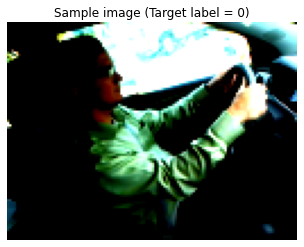

In [ ]:
# get the 0th sample
sample_image, sample_label = next(iter(image_loader))
print('Input image shape = ', sample_image.shape)
fig, axs = plt.subplots()
axs.imshow(sample_image.permute(1,2,0).numpy())
axs.axis('off')
axs.set_title('Sample image (Target label = {})'.format(sample_label))
plt.show()

In [ ]:
# number of images in training set
len(image_loader)

6283

## 2 Model Results visualization

In [ ]:
#load best performing vgg16 model
checkpoint = torch.load(os.path.join(model_path, 'vgg16_initial_net.pt'))

In [ ]:
#load model state
vgg_initial=Vgg16_initial()
vgg_initial.load_state_dict(checkpoint['model_state_dict'])
optimize_params = {
    "optimizer_type": "sgd", # can change to "adam"
    "lr": 0.005,
    "weight_decay": 0.005,
    "momentum": 0.9, # parameter for sgd
    "betas": (0.9, 0.999)} # parameter for adam
optimizer = get_optimizer(vgg_initial, optimize_params)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(96, 128, 3)
(96, 128, 3)
(96, 128, 3)
(96, 128, 3)
(96, 128, 3)


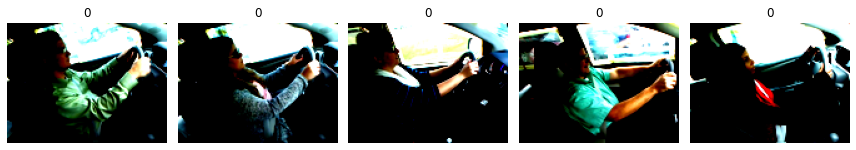

In [ ]:
#visualization some sample images
plt.figure(figsize=(12, 6))
loader=iter(image_loader)
for i in range(5):
    plt.subplot(1, 5, i + 1)
    sample_image, sample_label = next(loader)
    print(sample_image.permute(1,2,0).numpy().shape)
    plt.imshow(sample_image.permute(1,2,0).numpy())
    plt.title(sample_label)
    plt.axis('off')
plt.gcf().tight_layout()

In [ ]:
#randomly select 1 image from each class for further visualization
import random
import torchvision.transforms as transforms
import numpy as np
path_list=image_loader.dataset
transform = transforms.Compose([transforms.Resize((96,128)),
    	                                 transforms.ToTensor(),
    	                                 transforms.Normalize([0.31437435026332544, 0.3805657139133703, 0.3733153854924628], 
                                                              [0.29172749892553, 0.3331829868413413, 0.3351285321390462])
                                         ])
X=[]
y=[]
for i in range(10):
  img=image_loader.load_img_from_path(random.choice([x[0] for x in path_list if x[1]==i]))
  X.append(transform(img).numpy())
  y.append(i)
X=np.array(X)
y=np.array(y)

### 2.1 Saliency

In [ ]:
from torch.autograd import Variable
def compute_saliency_maps(X, y, model):
    """
    Compute a class saliency map using the model for images X and labels y.

    Input:
    - X: Input images; Tensor of shape (N, 3, H, W)
    - y: Labels for X; LongTensor of shape (N,)
    - model: A pretrained CNN that will be used to compute the saliency map.

    Returns:
    - saliency: A Tensor of shape (N, H, W) giving the saliency maps for the input
    images.
    """
    # Make sure the model is in "test" mode
    model.eval()
    
    # Wrap the input tensors in Variables
    X_var = Variable(X, requires_grad=True)
    y_var = Variable(y, requires_grad=False)
    saliency = None

    lam = 1e3 # This is the regularization parameter when you need it
    
   
    temp=model(X_var).gather(1, y.view(-1, 1)).squeeze()
    temp.backward(torch.ones(temp.shape[0]))
    saliency, i=torch.max(torch.abs(X_var.grad),dim=1)
   
    return saliency

In [ ]:
def show_saliency_maps(X, y):
    # Convert X and y from numpy arrays to Torch Tensors
    X_tensor = torch.Tensor(X)
    y_tensor = torch.LongTensor(y)

    # Compute saliency maps for images in X
    saliency = compute_saliency_maps(X_tensor, y_tensor, vgg_initial)
    # Convert the saliency map from Torch Tensor to numpy array and show images
    # and saliency maps together.
    saliency = saliency.numpy()

    N = X.shape[0]
    for i in range(N):
        #plt.subplot(2, N, i + 1)
        plt.imshow(X[i].transpose(1,2,0))
        plt.show()
        plt.axis('off')
        plt.title(i)
        #plt.subplot(2, N, N + i + 1)
        plt.imshow(saliency[i], cmap=plt.cm.gray)
        plt.show()
        plt.axis('off')
        #plt.gcf().set_size_inches(12, 5)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


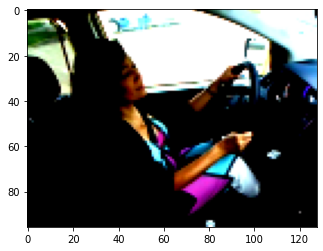

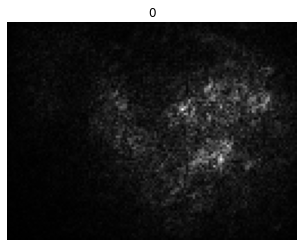

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


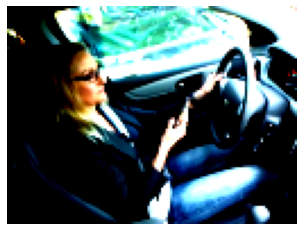

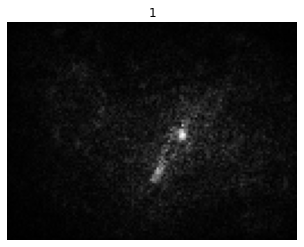

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


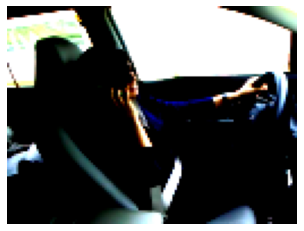

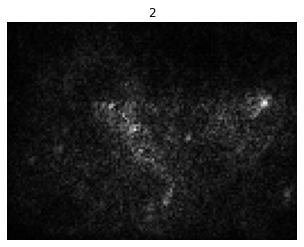

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


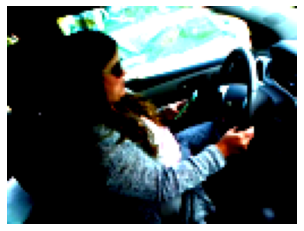

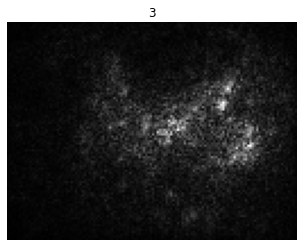

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


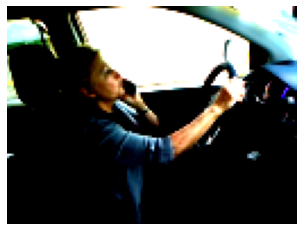

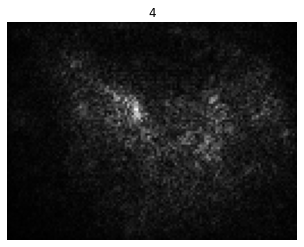

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


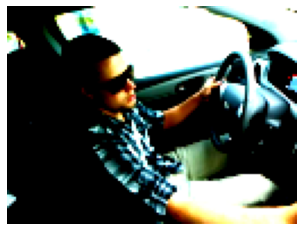

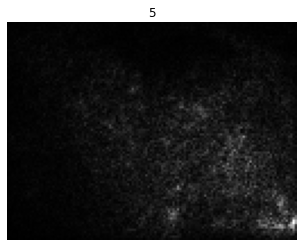

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


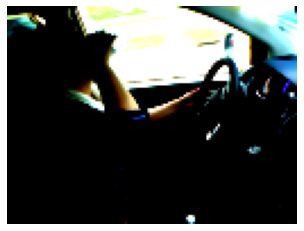

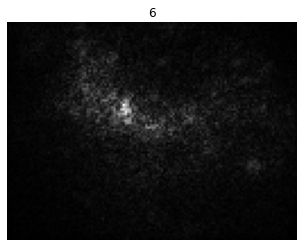

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


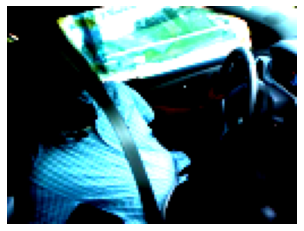

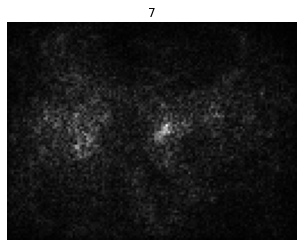

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


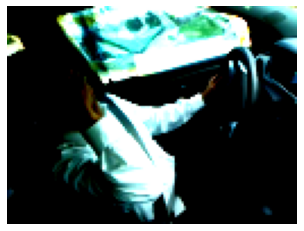

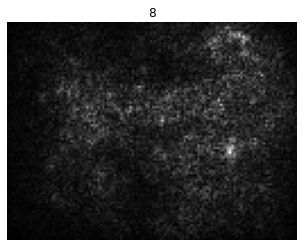

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


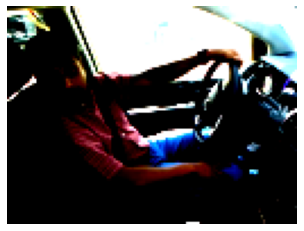

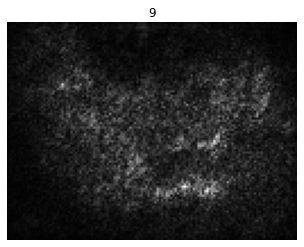

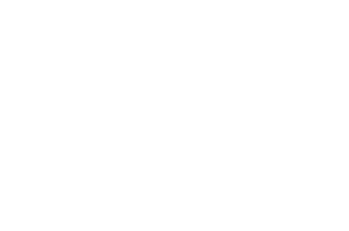

In [ ]:
from PIL import Image
show_saliency_maps(X, y)

In [ ]:
!pip install captum

/usr/local/lib/python3.6/dist-packages/captum/_utils/gradient.py:55: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


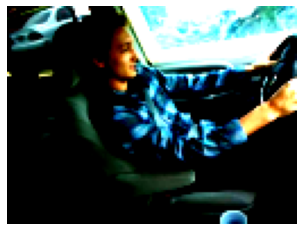

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


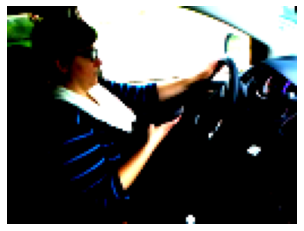

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


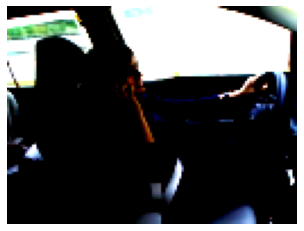

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


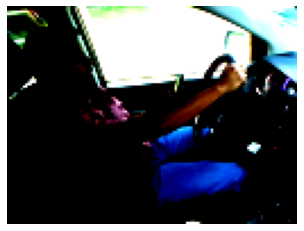

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


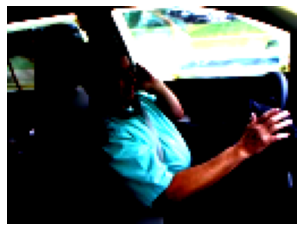

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


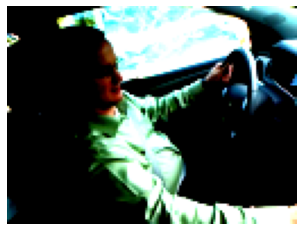

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


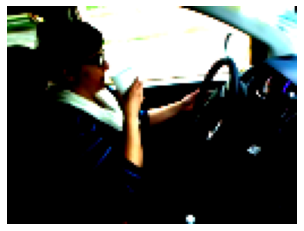

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


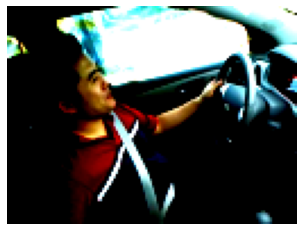

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


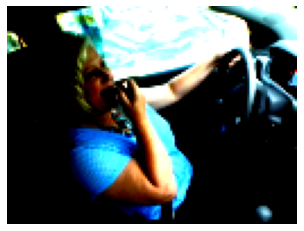

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


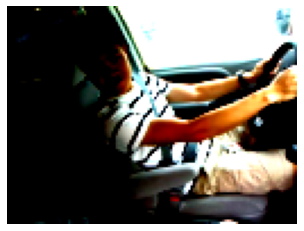

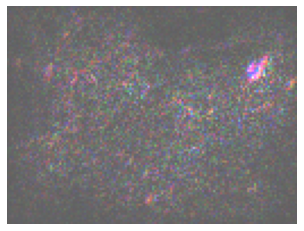

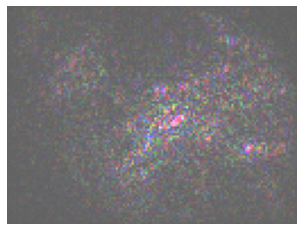

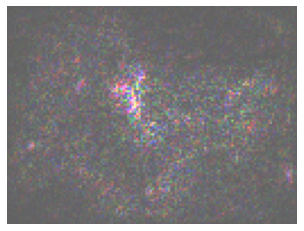

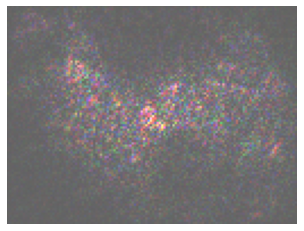

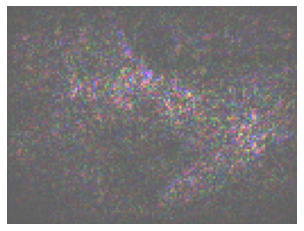

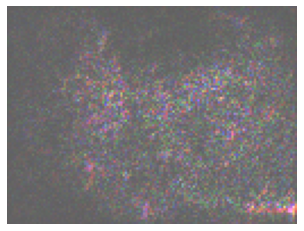

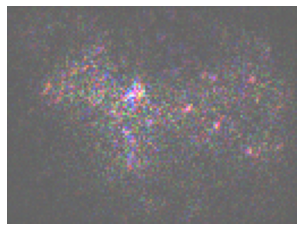

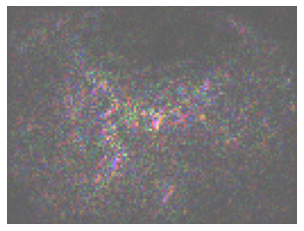

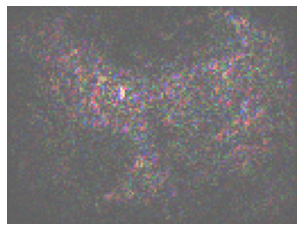

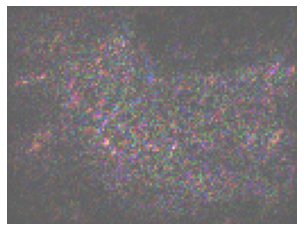

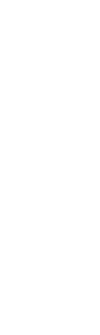

In [ ]:
import captum
def visualize_attr_maps(attributions, titles, attr_preprocess=lambda attr: attr.permute(1, 2, 0).detach().numpy(),
                        cmap='viridis', alpha=0.7):
    '''
    A helper function to visualize captum attributions for a list of captum attribution algorithms.
    
    attributions(A list of torch tensors): Each element in the attributions list corresponds to an
                      attribution algorithm, such an Saliency, Integrated Gradient, Perturbation, etc.
                      Each row in the attribution tensor contains
    titles(A list of strings): A list of strings, names of the attribution algorithms corresponding to each element in
                      the `attributions` list. len(attributions) == len(titles)
    '''
    N = attributions[0].shape[0]
    plt.figure()
    plt.axis('off')
    for i in range(N):
        #axs = plt.subplot(len(attributions) + 1, N + 1, i+1)
        plt.imshow(X[i].transpose(1,2,0))
        plt.show()
        plt.axis('off')
        #plt.title(y[i])

    #plt.subplot(len(attributions) + 1, N + 1 , N + 1)    
    #plt.text(0.0, 0.5, 'Original Image', fontsize=14)
    plt.axis('off')
    for j in range(len(attributions)):
        for i in range(N):
            #plt.subplot(len(attributions) + 1, N + 1 , (N + 1) * (j + 1) + i + 1)
            attr = np.array(attr_preprocess(attributions[j][i]))
            attr = (attr - np.mean(attr)) / np.std(attr).clip(1e-20)
            attr = attr * 0.1 + 0.2
            attr = attr.clip(0.0, 1.0)
            plt.imshow(attr, cmap=cmap, alpha=alpha)
            plt.show()
            plt.axis('off')
        plt.subplot(len(attributions) + 1, N + 1 , (N + 1) * (j + 1) + N + 1)    
        #plt.text(0.0, 0.5, titles[j], fontsize=14)
        plt.axis('off')

    plt.gcf().set_size_inches(20, 13)
    plt.show()
def compute_attributions(algo, inputs, **kwargs):
    '''
    A common function for computing captum attributions
    '''
    return algo.attribute(inputs, **kwargs)

vgg_initial=Vgg16_initial()
vgg_initial.load_state_dict(checkpoint['model_state_dict'])
from captum.attr import IntegratedGradients, Saliency

    
# Convert X and y from numpy arrays to Torch Tensors
X_tensor = torch.Tensor(X)
y_tensor = torch.LongTensor(y)


sal=compute_attributions(Saliency(vgg_initial),X_tensor, target=y_tensor)
visualize_attr_maps([sal], ['Saliency'])


### 2.2 Gradcam

In [ ]:
gc_model = Vgg16_initial()
gc_model.load_state_dict(checkpoint['model_state_dict'])
for param in gc_model.parameters():
    param.requires_grad = True

In [ ]:
conv_module = gc_model.cnn_layers[40]

gradient_value = None # Stores gradient of the module you chose above during a backwards pass.
activation_value = None # Stores the activation of the module you chose above during a forwards pass.

def gradient_hook(a,b,gradient):
    global gradient_value
    gradient_value = gradient[0]
    
def activation_hook(a,b,activation):
    global activation_value
    activation_value = activation

conv_module.register_forward_hook(activation_hook)
conv_module.register_backward_hook(gradient_hook)

In [ ]:
def grad_cam(X_tensor, y_tensor):
    temp=gc_model(X_tensor).gather(1, y_tensor.view(-1, 1)).squeeze()
    temp.sum().backward()
    N,C,H,W=gradient_value.shape
    grad= gradient_value.view(N, C, -1) 
    avg_pools=grad.sum(dim=2)/(H*W)
    avg_pools = avg_pools[:,:, np.newaxis,np.newaxis]
    cam=(activation_value*avg_pools).sum(dim=1).detach().numpy()
    
    
    # Rescale GradCam output to fit image.
    cam_scaled = []
    for i in range(cam.shape[0]):
        cam_scaled.append(np.array(Image.fromarray(cam[i]).resize(X_tensor[i,0,:,:].shape)))
    cam = np.array(cam_scaled)
    cam -= np.min(cam)
    cam /= np.max(cam)
    return cam

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


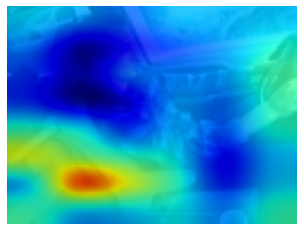

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


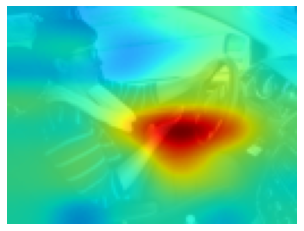

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


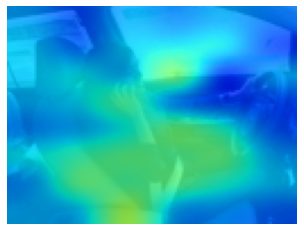

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


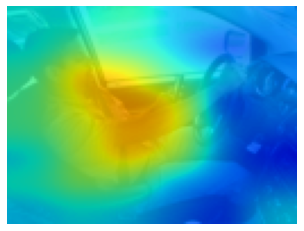

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


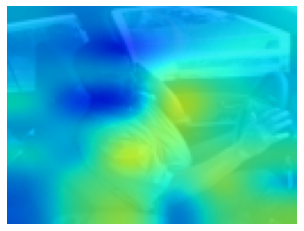

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


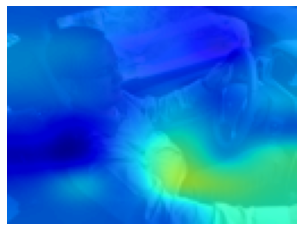

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


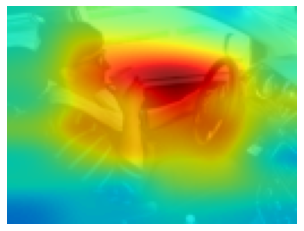

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


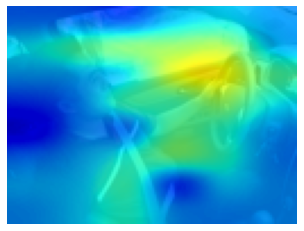

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


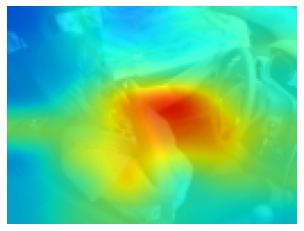

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


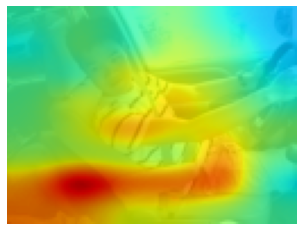

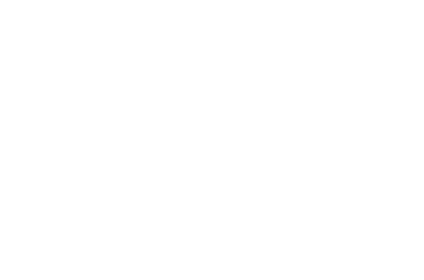

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
X_tensor = torch.Tensor(X).requires_grad_(True)
y_tensor = torch.LongTensor(y)
gradcam_result = grad_cam(X_tensor, y_tensor)

#plt.figure(figsize=(24, 24))
plt.axis('off')
for i in range(gradcam_result.shape[0]):
    gradcam_val = gradcam_result[i]
    img = X[i].transpose(1,2,0) + (matplotlib.cm.jet(gradcam_val)[:,:,:3].transpose(1,0,2)*12)
    img = img / np.max(img)
    #plt.subplot(1, 10, i + 1)
    plt.imshow(img)
    plt.show()
    #plt.title(y[i])
    plt.axis('off')
    #plt.gcf().set_size_inches(60, 25)
plt.gcf().tight_layout()

### 2.3 Gudied GradCam

/usr/local/lib/python3.6/dist-packages/captum/_utils/gradient.py:55: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index
/usr/local/lib/python3.6/dist-packages/captum/attr/_core/guided_backprop_deconvnet.py:61: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  "Setting backward hooks on ReLU activations."
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


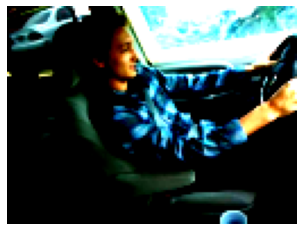

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


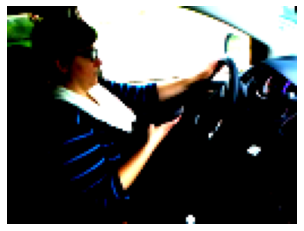

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


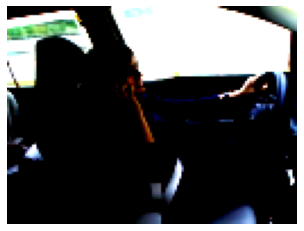

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


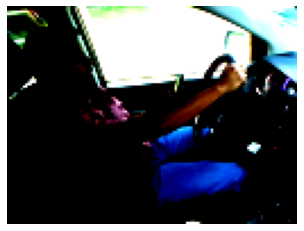

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


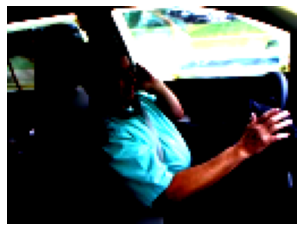

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


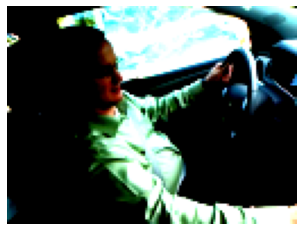

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


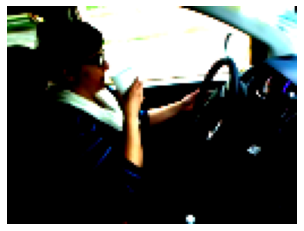

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


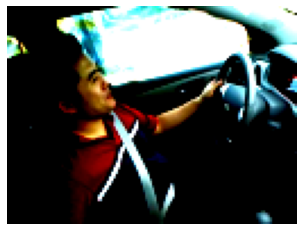

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


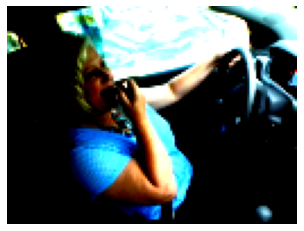

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


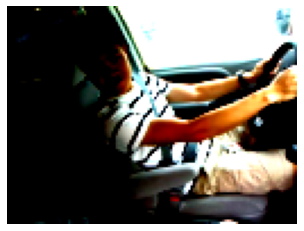

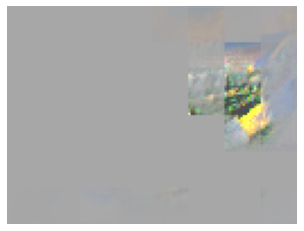

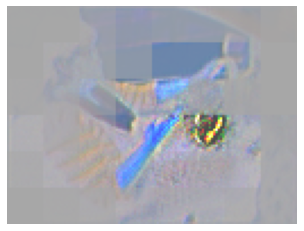

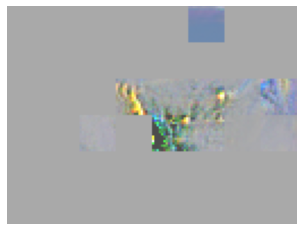

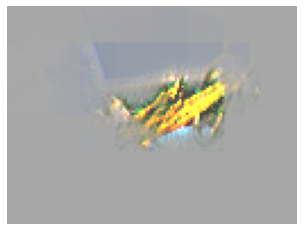

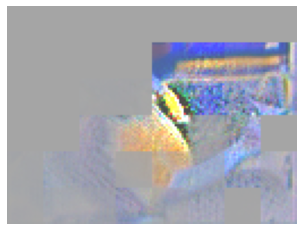

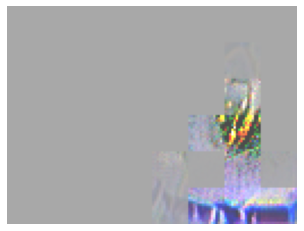

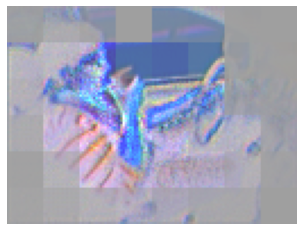

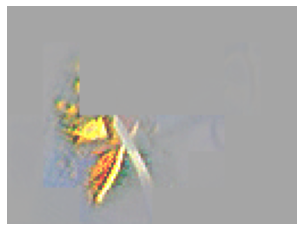

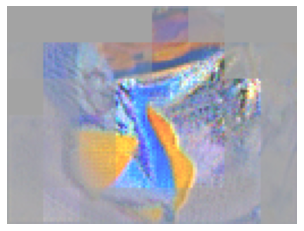

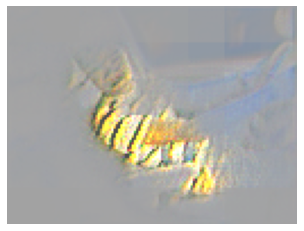

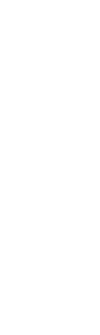

In [ ]:
gc_model = Vgg16_initial()
gc_model.load_state_dict(checkpoint['model_state_dict'])
for param in gc_model.parameters():
    param.requires_grad = True
from captum.attr import GuidedGradCam, GuidedBackprop

def visualize_attr_maps(attributions, titles, attr_preprocess=lambda attr: attr.permute(1, 2, 0).detach().numpy(),
                        cmap='viridis', alpha=0.7):
    '''
    A helper function to visualize captum attributions for a list of captum attribution algorithms.
    
    attributions(A list of torch tensors): Each element in the attributions list corresponds to an
                      attribution algorithm, such an Saliency, Integrated Gradient, Perturbation, etc.
                      Each row in the attribution tensor contains
    titles(A list of strings): A list of strings, names of the attribution algorithms corresponding to each element in
                      the `attributions` list. len(attributions) == len(titles)
    '''
    N = attributions[0].shape[0]
    plt.figure()
    plt.axis('off')
    for i in range(N):
        #axs = plt.subplot(len(attributions) + 1, N + 1, i+1)
        plt.imshow(X[i].transpose(1,2,0))
        plt.show()
        plt.axis('off')
        #plt.title(y[i])

    #plt.subplot(len(attributions) + 1, N + 1 , N + 1)    
    #plt.text(0.0, 0.5, 'Original Image', fontsize=14)
    plt.axis('off')
    for j in range(len(attributions)):
        for i in range(N):
            #plt.subplot(len(attributions) + 1, N + 1 , (N + 1) * (j + 1) + i + 1)
            attr = np.array(attr_preprocess(attributions[j][i]))
            attr = (attr - np.mean(attr)) / np.std(attr).clip(1e-20)
            attr = attr * 0.2 + 0.5
            attr = attr.clip(0.0, 1.0)
            plt.imshow(attr, cmap=cmap, alpha=alpha)
            plt.show()
            plt.axis('off')
        plt.subplot(len(attributions) + 1, N + 1 , (N + 1) * (j + 1) + N + 1)    
        #plt.text(0.0, 0.5, titles[j], fontsize=14)
        plt.axis('off')

    plt.gcf().set_size_inches(20, 13)
    plt.show()
    
# Convert X and y from numpy arrays to Torch Tensors
X_tensor = torch.Tensor(X)
y_tensor = torch.LongTensor(y)

ggc=compute_attributions(GuidedGradCam(gc_model,gc_model.cnn_layers[40]),X_tensor, target=y_tensor)
visualize_attr_maps([ggc], ['GuidedGradCam'])

### 2.4 Guided Backprop

/usr/local/lib/python3.6/dist-packages/captum/_utils/gradient.py:55: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index
/usr/local/lib/python3.6/dist-packages/captum/attr/_core/guided_backprop_deconvnet.py:61: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  "Setting backward hooks on ReLU activations."
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


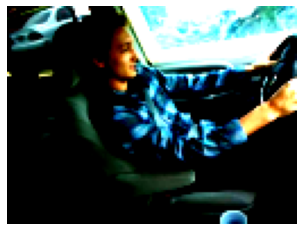

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


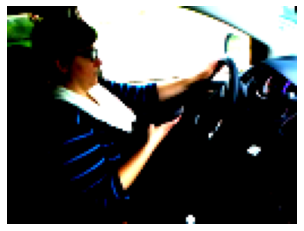

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


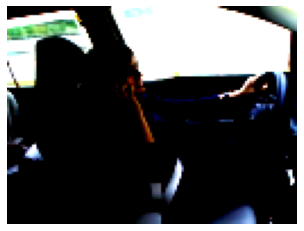

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


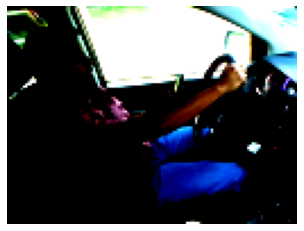

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


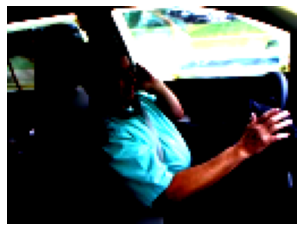

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


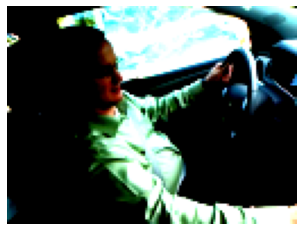

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


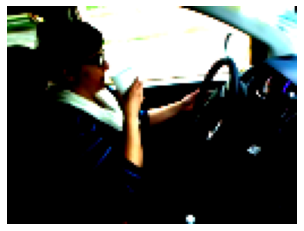

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


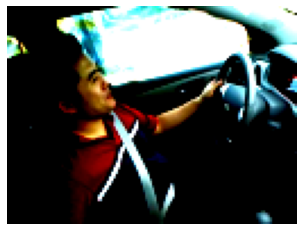

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


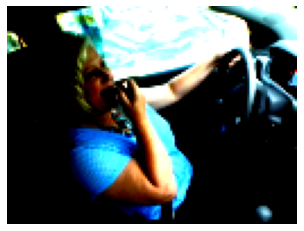

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


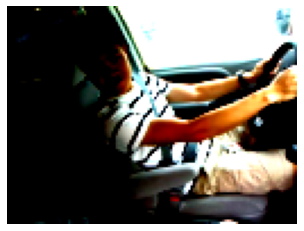

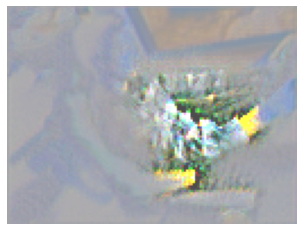

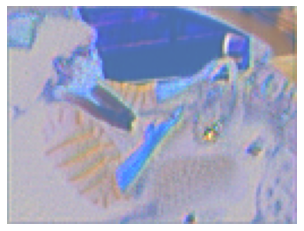

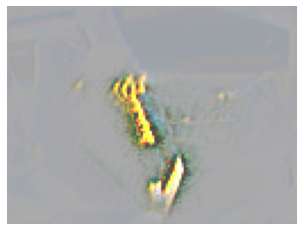

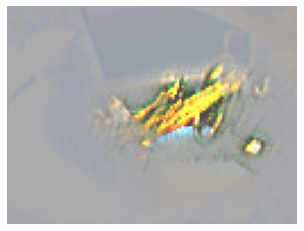

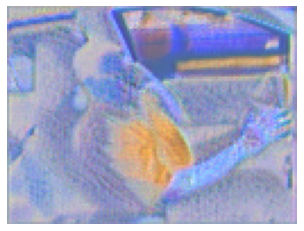

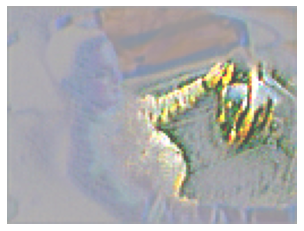

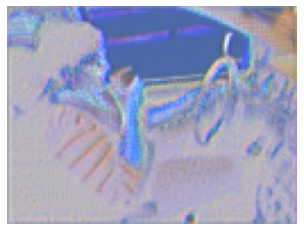

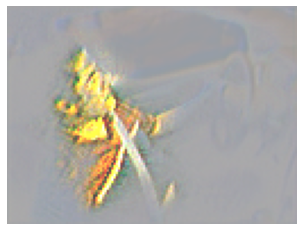

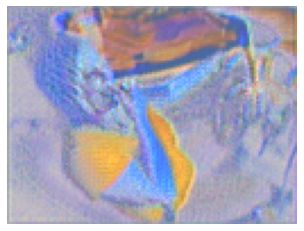

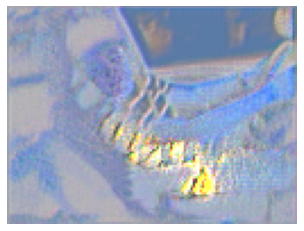

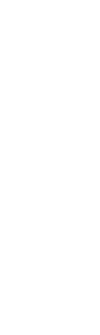

In [ ]:
gc_model = Vgg16_initial()
gc_model.load_state_dict(checkpoint['model_state_dict'])
for param in gc_model.parameters():
    param.requires_grad = True
from captum.attr import GuidedGradCam, GuidedBackprop

    
# Convert X and y from numpy arrays to Torch Tensors
X_tensor = torch.Tensor(X)
y_tensor = torch.LongTensor(y)


gbp=compute_attributions(GuidedBackprop(gc_model),X_tensor, target=y_tensor)
visualize_attr_maps([gbp], ['GuidedBackprop'])